In [1]:
# Add path
import sys
sys.path.insert(1, '../Scripts')

# Packages for Our filters
import measfilter as mf # package for measurement error filter
import gatesimu as gs # package for gate and measurment error filter

from qiskit import IBMQ, QuantumRegister, transpile, execute
# Package for Qiskit error filter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)

# Package for other Qiskit functions
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram


# Needed for functions
import numpy as np
import matplotlib.pyplot as plt

Formal Installation


../Scripts\gatesimu.py:22: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


# Tutorial

## Section 1: Measurmenet Error
### Create filter for measurment error

First, we choose a backend to operate.

In [2]:
# Load Account and Choose Backend
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmq_belem' 
backend = provider.get_backend(name) 

We plan to run Grover's search whose solution is 11. So we first look at which quibits we will need to get information. The circuit will run on Qubit 0, 1, and 2. But the measurment operation is only on Qubit 1 and 2.

In [3]:
interested_qubits = [2,1] # Descending order because Qiskit's readout is little-endian

Now we collect data for our filter. Here we make `if_write=True` so that we can save the data and re-create the filter anytime we want. But no matter if `if_write=True` or not, a file that records backend proporties will be generated under `file_address`. if `file_address` is an empty string, the data will be saved where the script runs, otherwise `file_address` need to end with `/`.

By default, `itr * shots / 1024` number of data points will be used for Bayesian inference latter. `32 * 8192` usually takes a few minutes.

In [4]:
itr = 32
shots = 8192
file_address = ''
readout = mf.collect_filter_data(backend, itr=itr,shots=shots,if_monitor_job=True,if_write=True,file_address=file_address)

Job Status: job has successfully run


Collect data for the measurement error filter in Qiskit. So we can do a comparison at the end.

In [5]:
qr = QuantumRegister(len(interested_qubits))
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
for i in range(len(meas_calibs)):
    meas_calibs[i] = transpile(meas_calibs[i],backend,initial_layout=interested_qubits) # Make sure the same qubits are used

job = execute(meas_calibs, backend=backend,shots=8192,optimization_level=0)
job_monitor(job)

cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
meas_filter = meas_fitter.filter

Job Status: job has successfully run


Then we can create our filter and run `inference()` to inference the data. If  `inference()` is run once, `post_from_file()` can directly read previous posteriors.

Qubit 4
Given Lambdas [0.967  0.9775]


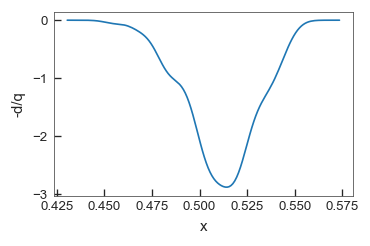

Final Accepted Posterior Lambdas
M: 2.87775 Maximizer: 0.514181 pi_obs = 23.9489 pi_Q(prior) = 8.32208
Progress: 99.997%
Accepted Number N: 13939, fraction 0.348
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.93220964 0.9134171 ]
Posterior Lambda Mode [0.95884258 0.92692584]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000684333
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


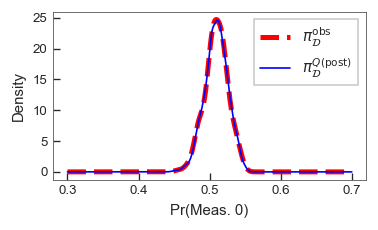

Qubit 3
Given Lambdas [0.9628 0.9728]


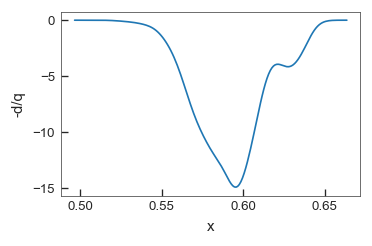

Final Accepted Posterior Lambdas
M: 14.8848 Maximizer: 0.595348 pi_obs = 15.1737 pi_Q(prior) = 1.0194
Progress: 99.997%
Accepted Number N: 2597, fraction 0.065
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.95531897 0.79991974]
Posterior Lambda Mode [0.98538946 0.80402951]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000976973
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


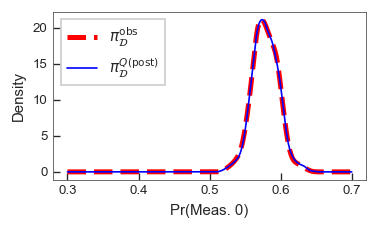

In [9]:
Cons_filter = mf.MeasFilter(interested_qubits, file_address=file_address)
Cons_filter.inference(nPrior=40000, Priod_sd=0.1, seed=127, shots_per_point=1024)
#Cons_filter.post_from_file() # if inference() is already run once

In [10]:
Cons_filter.mean()

{'Qubit4': array([0.93220964, 0.9134171 ]),
 'Qubit3': array([0.95531897, 0.79991974])}

In [11]:
Cons_filter.mode()

{'Qubit4': array([0.95884258, 0.92692584]),
 'Qubit3': array([0.98538946, 0.80402951])}

### Grover's search Experiment

Run provided Grover's search experiment, the counts will be written to `Count_Grover.csv`. Then we read the data back.

In [7]:
from expfuncs import Groverexp
Groverexp(backend, file_address=file_address)

Grover circuit depth is  45
Job Status: job has successfully run


In [12]:
# Read Grover data
import csv
with open(file_address + 'Count_Grover.csv', mode='r') as sgm:
    reader = csv.reader(sgm)
    temp_counts = {}
    for row in reader:   
        temp_counts[row[0]] = int(row[1])
real_counts = {}
for key in temp_counts.keys():
    real_counts[key[0:2]] = temp_counts[key] # we only measurmeent last two qubits, so slice the keys

In [13]:
qis_counts = meas_filter.apply(real_counts)
mean_counts = Cons_filter.filter_mean(real_counts)
mode_counts = Cons_filter.filter_mode(real_counts)

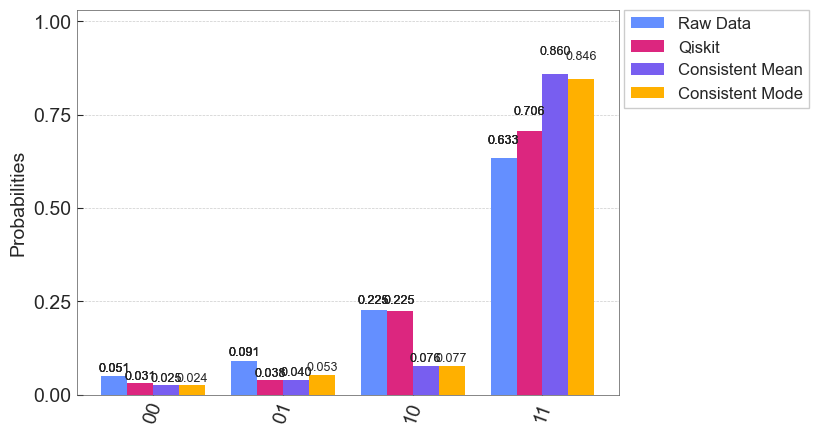

In [14]:
legend = ['Raw Data', 'Qiskit', 'Consistent Mean', 'Consistent Mode']
plot_histogram([real_counts, qis_counts, mean_counts, mode_counts], legend=legend)

## Section 2: Gate and Measurmenet Error

In [8]:
interested_qubits = [4,3]
gate_num = 500
gate_type = 'X'

# Collect U3-Gate Data
for q in interested_qubits:
    gs.Gateexp(gate_num, gate_type, q, itr, backend, file_address =file_address)

Circ depth is  501
Job Status: job has successfully run
Circ depth is  501
Job Status: job has successfully run


In [15]:
# Read data back
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[1]), mode='r') as measfile:
    reader = csv.reader(measfile)    
    data1 = np.asarray([row for row in reader][0])
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[0]), mode='r') as measfile:
    reader = csv.reader(measfile) 
    data2 = np.asarray([row for row in reader][0])

Qubit 4
Given Lambdas [9.67000000e-01 9.77500000e-01 5.51451386e-04]


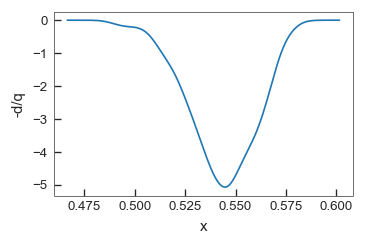

Final Accepted Posterior Lambdas
M: 5.07289 Maximizer: 0.544749 pi_obs = 24.6888 pi_Q(prior) = 4.86682
Accepted Number N: 7931, fraction 0.198
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.93014634 0.89460368 0.00788589]
Posterior Lambda Mode [0.97381732 0.89394781 0.0062886 ]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000945981
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


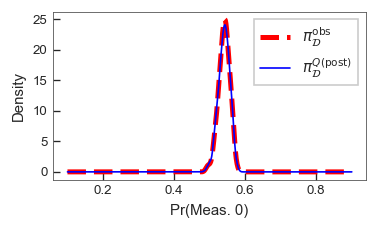

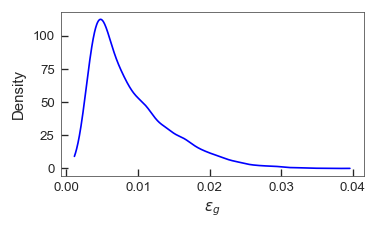

Qubit 3
Given Lambdas [9.6280000e-01 9.7280000e-01 5.9942639e-04]


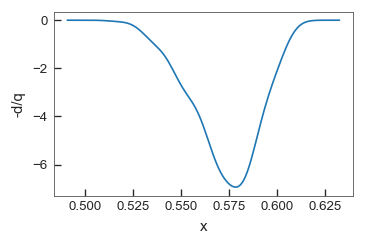

Final Accepted Posterior Lambdas
M: 6.93963 Maximizer: 0.578419 pi_obs = 21.423 pi_Q(prior) = 3.08705
Accepted Number N: 5693, fraction 0.142
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.93077017 0.87472622 0.00701068]
Posterior Lambda Mode [0.98105644 0.8626898  0.00526612]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00191024
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


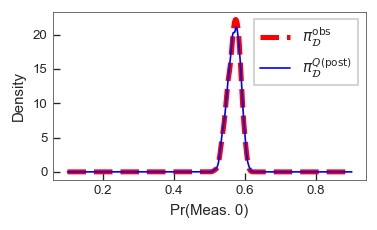

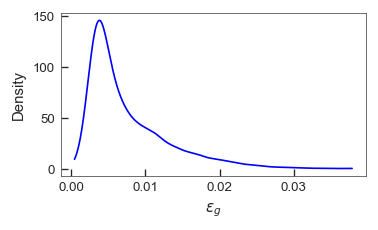

In [16]:
gs_filter = gs.GMFilter(interested_qubits,gate_num, gate_type, device_param_address=file_address, data_file_address=file_address)
gs_filter.inference(nPrior=40000, meas_sd=0.1, gate_sd=0.01, seed=127, shots_per_point=1024)
# gs_filter.post_from_file()

In [17]:
# Read data back
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[1]), mode='r') as measfile:
    reader = csv.reader(measfile)    
    data1 = np.asarray([row for row in reader][0])
with open(file_address + 'Readout_{}{}Q{}.csv'.format(gate_num, gate_type, interested_qubits[0]), mode='r') as measfile:
    reader = csv.reader(measfile) 
    data2 = np.asarray([row for row in reader][0])
    
p0s1 = mf.getData0(data1, 128, interested_qubits[1])
p0s2 = mf.getData0(data2, 128, interested_qubits[0])

In [18]:
Q1CB = gs_filter.filter_mean(p0s1, interested_qubits[1])
Q2CB = gs_filter.filter_mean(p0s2, interested_qubits[0])

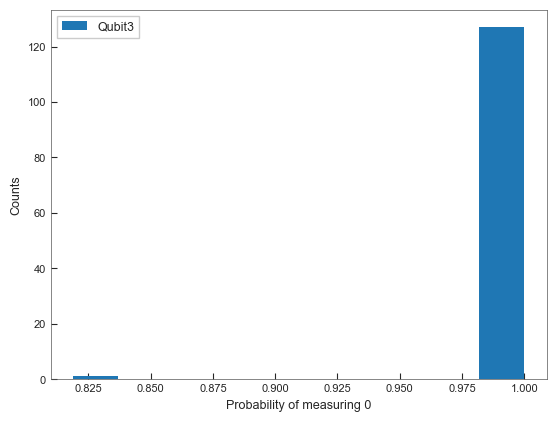

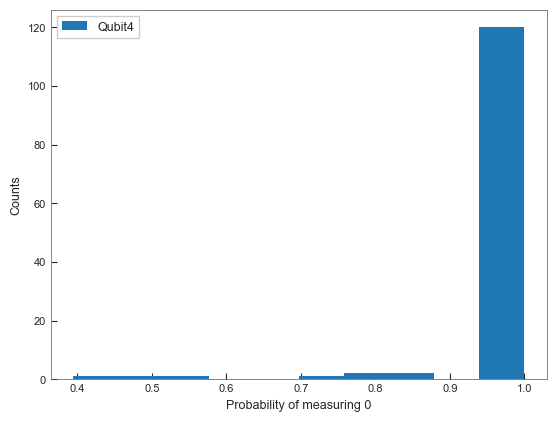

In [19]:
plt.hist(Q1CB, label = 'Qubit{}'.format(interested_qubits[1]))
plt.xlabel('Probability of measuring 0')
plt.ylabel('Counts')
plt.legend()
plt.show()
plt.hist(Q2CB, label = 'Qubit{}'.format(interested_qubits[0]))
plt.xlabel('Probability of measuring 0')
plt.ylabel('Counts')
plt.legend()
plt.show()